In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame = False) 

In [2]:
X,y = mnist.data, mnist.target

In [3]:
X.shape

(70000, 784)

In [4]:
import matplotlib.pyplot as plt

def plot_image(image):
    image = image.reshape(28,28)
    plt.imshow(image,cmap = "binary")
    plt.axis("off")


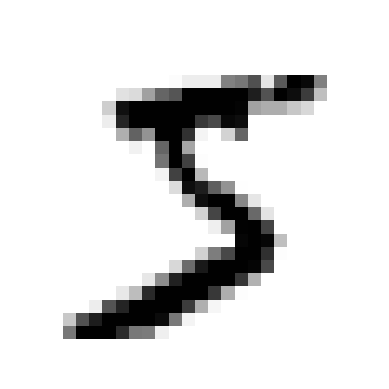

In [5]:
some_digit = X[0]
plot_image(some_digit)

In [6]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

Binary classifier:

In [7]:
y_train_5 = y_train == '5'
y_test_5 = y_test == '5'
y_train_5

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_classifier  = SGDClassifier(random_state= 42)
sgd_classifier.fit(X_train,y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [9]:
sgd_classifier.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier,X_train,y_train_5, cv = 3,scoring = "accuracy")



array([0.95035, 0.96035, 0.9604 ])

The DummyClassifier classifies every single image in the most frequent class, wich in this case is the non five's

In [11]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier()

dummy_classifier.fit(X_train,y_train_5)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'prior'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [12]:
print(any(dummy_classifier.predict(X_train)))

False


In [13]:
cross_val_score(dummy_classifier,X_train,y_train_5,cv = 3, scoring = "accuracy")

array([0.90965, 0.90965, 0.90965])

This is simply because only about 10% of the dataset are 5s, so if you guess always that an image is not a five, you will be right about 90% of the time

A much better way to evaluate the perfomance of a classifier is to lookm at the confusion matrix (CM)

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_classifier,X_train,y_train_5,cv = 3)

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred = y_train_predict, y_true = y_train_5)
cm

array([[53892,   687],
       [ 1891,  3530]])

The first row is the non 5s, 53892 were correctly classified as non 5s (True negatives), while 687 were classified wrongly as 5s (False positives)

The first row is the class of 5s, 1891 were wrongly classified as non 5s (False negative) and 3530 correctly classified as non 5s (True positives)

PRECISION AND RECALL

In [16]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_predict)

0.8370879772350012

In [17]:
recall_score(y_train_5,y_train_predict)

0.6511713705958311

Incresing precision reduces recall, and vice versa. (Precision/recall trade off)

In [18]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_prediction = y_scores > threshold
y_some_digit_prediction

array([ True])

In [20]:
threshold = 3000
y_some_digit_prediction = y_scores > threshold
y_some_digit_prediction

array([False])

Raising the threshold increases recall and decreases precision

In [21]:
y_scores = cross_val_predict(sgd_classifier,X_train,y_train_5,cv = 3, method = "decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

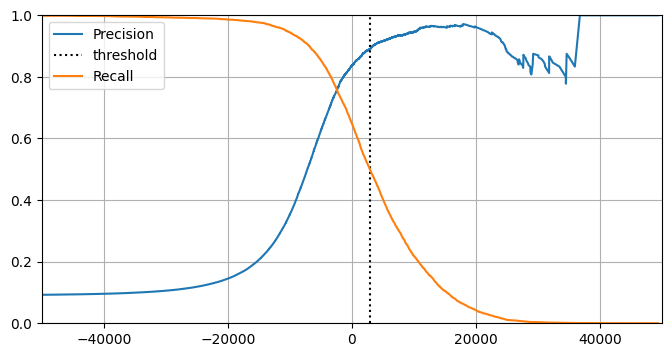

In [23]:
plt.figure(figsize = (8,4))
plt.plot(thresholds,precisions[:-1], label = "Precision")
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.plot(thresholds,recalls[:-1], label =  "Recall")
plt.axis([-50000,50000,0,1])
plt.grid(True)
plt.legend()
plt.savefig(fname = "precision-recall-thresholds")
plt.show()

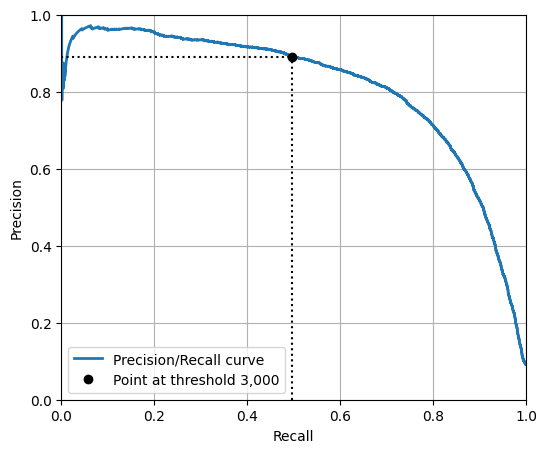

In [24]:
import matplotlib.patches as patches  # extra code – for the curved arrow

idx = (thresholds >= threshold).argmax()

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.axis([0,1,0,1])
plt.grid(True)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.savefig("Precision versus recall SGDClassifier")
plt.show()

We are seeking for 90% precision. We can search for the lowest threshold that gives at least 90%

In [25]:
idx_for_90 = (precisions >= 0.9).argmax()
threshold_for_90 = thresholds[idx_for_90]
threshold_for_90

np.float64(3370.0194991439557)

In [26]:
y_pred_90 = y_scores >= threshold_for_90

In [27]:
precision_score(y_train_5,y_pred_90)

0.9000345901072293

In [28]:
recall_at_90 = recall_score(y_train_5,y_pred_90)
recall_at_90

0.4799852425751706

The ROC curve plots the FPR (False positive rate) versus TNR (True negative rate)

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr,thresholds = roc_curve(y_train_5,y_scores)

In [30]:
index_for_threshold_at_90 = (thresholds <= threshold_for_90).argmax()

tpr_90, fpr_90 = tpr[index_for_threshold_at_90] , fpr[index_for_threshold_at_90]

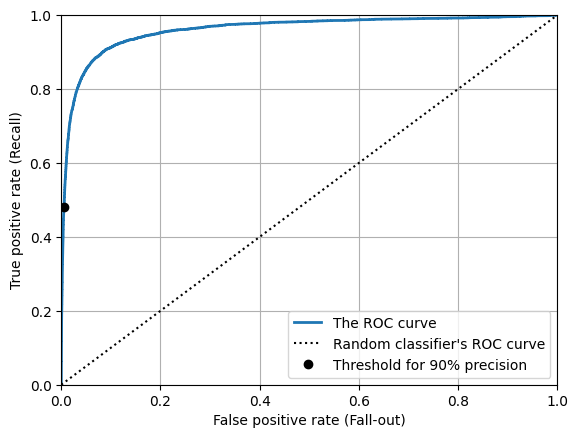

In [31]:
plt.plot(fpr,tpr,linewidth = 2,label = "The ROC curve")
plt.plot([0,1],[0,1],'k:', label = "Random classifier's ROC curve")
plt.plot([fpr_90],[tpr_90], 'ko',label = "Threshold for 90% precision")
plt.xlabel("False positive rate (Fall-out)")
plt.ylabel("True positive rate (Recall)")
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.savefig("TPR versus FPR of the SGDClassifier")
plt.show()

A good classifier has a curve as far as possible from the dotted one, because she represents a roc curve for a random classifier

AUC (Area under the curve)

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Now, using a RandomForestClassifier:

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state = 42)

In [34]:
y_probas_forest_classifier = cross_val_predict(forest_classifier,X_train,y_train_5,cv = 3,method = "predict_proba")

In [35]:
y_probas_forest_classifier[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [36]:
y_scores_forest = y_probas_forest_classifier[:, 1]

precision_forest, recall_forest,thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)

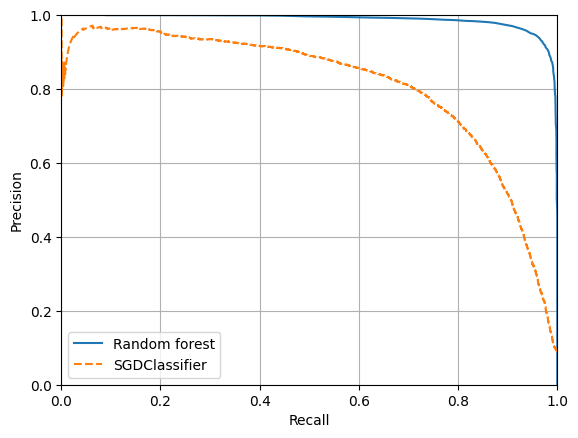

In [37]:
plt.plot(precision_forest,recall_forest, label = "Random forest")
plt.plot(recalls, precisions,"--" ,label = "SGDClassifier")
plt.legend()
plt.grid()
plt.axis([0,1,0,1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("Comparison between RandomForest and SGDClassifier (PR Curve)")
plt.show()

In [38]:
y_pred_forest = y_probas_forest_classifier[: , 1].round() == True
y_pred_forest


array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [39]:
prec_forest , recall_for = precision_score(y_train_5,y_pred_forest), recall_score(y_train_5,y_pred_forest)

In [40]:
print(f"Precision: {prec_forest}")
print(f"Recall: {recall_for}")

Precision: 0.9905083315756169
Recall: 0.8662608374838591


MULTICLASS CLASSIFICATION:

In [41]:
from sklearn.svm import SVC

svc_classifier = SVC(random_state = 42)

svc_classifier.fit(X_train[:2000], y_train[:2000])

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [42]:
svc_classifier.predict([some_digit])

array(['5'], dtype=object)

In [43]:
some_digit_score = svc_classifier.decision_function([some_digit])
some_digit_score.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [44]:
class_id = some_digit_score.argmax()
class_id

np.int64(5)

In [45]:
svc_classifier.classes_[class_id]

'5'

Using now a SGDC Classifier with OvR strategy

In [46]:
sgd_classifier = SGDClassifier(random_state = 42)
sgd_classifier.fit(X_train,y_train)
sgd_classifier.predict([some_digit])

array(['3'], dtype='<U1')

In [47]:
sgd_classifier.decision_function([some_digit])

array([[-31893.03095419, -19047.55566534,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [48]:
cross_val_score(sgd_classifier,X_train,y_train,cv = 3, scoring = "accuracy")

array([0.87745, 0.85835, 0.8698 ])

We can make it better scaling the inputs

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_classifier,X_train_scaled,y_train,cv = 3, scoring = "accuracy")

c:\Users\kilep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\kilep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\kilep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.89835, 0.8902 , 0.90095])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_train = cross_val_predict(sgd_classifier, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,normalize = "true",values_format = ".0%")
plt.savefig("Confusion matrix  of SGD  classifier")
plt.show()

c:\Users\kilep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\kilep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\kilep\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'normalize'

MULTILABEL CLASSIFICATION

In [52]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [54]:
y_train_large = y_train >= '7'
y_train_odd = (y_train.astype('uint8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [55]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_multilabel)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [56]:
knn_classifier.predict([some_digit])

array([[False,  True]])

In [57]:
y_train_knn_pred = cross_val_predict(knn_classifier,X_train,y_multilabel,cv = 3)

In [58]:
y_train_knn_pred

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]], shape=(60000, 2))

Exercises

1

In [60]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [61]:
cross_val_score(knn_classifier,X_train,y_train,cv = 3, scoring = "accuracy")

array([0.9676 , 0.9671 , 0.96755])

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("knn_classifier", KNeighborsClassifier())
])

param_grid = [
    {'knn_classifier__weights': ['distance'],
     'knn_classifier__n_neighbors': [1,2,3]}
]

grid_search = GridSearchCV(pipeline,param_grid,scoring = 'accuracy',cv = 3)

In [80]:
grid_search.fit(X_train,y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'knn_classifier__n_neighbors': [1, 2, ...], 'knn_classifier__weights': ['distance']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2

In [103]:
predict = grid_search.best_estimator_.predict(X_test)

In [104]:
acc = (predict == y_test).mean()
acc

np.float64(0.9717)